In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from tensorflow.keras.layers import LSTM,GRU,Dense,Input,Concatenate
from tensorflow.keras.models import Model

In [2]:
df = pd.read_csv('./NewDataset/New_dataset_features.csv')
df = df.drop(['Unnamed: 0'],axis=1)
shops = [0,1,7,10,18,24,25,27,33,42,49,53,56,59]
for i in shops:
    df = df.drop(df[df['shop_id']==i].index)
categories = [0,1,9,12,29,35,42,44,53,54,56,57,60,64,65,66,69,70,71,]
for i in categories:
    df = df.drop(df[df['item_category_id']==i].index)    
df.head()

,shop_id,item_category_id,average_price_per_shop,average_items_per_shop,average_items_per_category,month_0,month_1,month_2,month_3,month_4,...,month_24,month_25,month_26,month_27,month_28,month_29,month_30,month_31,month_32,month_33
83,2,2,1350.64,1.18,1.06,25.0,21.0,10.0,15.0,8.0,...,9.0,4.0,5.0,2.0,4.0,1.0,5.0,0.0,0.0,0.0
84,2,3,1350.64,1.18,1.18,9.0,6.0,2.0,2.0,2.0,...,24.0,7.0,10.0,11.0,8.0,7.0,15.0,13.0,27.0,16.0
85,2,4,1350.64,1.18,1.04,10.0,3.0,3.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
86,2,5,1350.64,1.18,1.03,10.0,4.0,1.0,2.0,4.0,...,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0
87,2,6,1350.64,1.18,1.11,12.0,8.0,11.0,6.0,4.0,...,14.0,2.0,4.0,5.0,4.0,9.0,3.0,7.0,6.0,8.0


In [3]:
def split_rnn(df, look_back):
    x1_ = df[['shop_id','item_category_id','average_price_per_shop','average_items_per_shop','average_items_per_category']]
    x1 = pd.DataFrame()
    x2 = pd.DataFrame()
    y = pd.DataFrame()
    for i in range(32-look_back):
        x2_aux = pd.DataFrame()
        for k in range(look_back):
            x2_ = df[['month_'+str(i+k)]]
            x2_ = x2_.rename(columns={'month_'+str(i+k):'month_'+str(k)})
            x2_aux = pd.concat([x2_aux,x2_],axis=1)
        y_ = df[['month_'+str(i+look_back)]]
        y_ = y_.rename(columns={'month_'+str(i+look_back):'month'})
        x1 = pd.concat([x1,x1_],axis=0)
        x2 = pd.concat([x2,x2_aux],axis=0)
        y = pd.concat([y,y_],axis=0)
    x1_test = pd.DataFrame()
    x2_test = pd.DataFrame()
    y_test = pd.DataFrame()
    for i in range(32-look_back,34-look_back,1):
        print(i)
        x2_aux = pd.DataFrame()
        for k in range(look_back):
            x2_t = df[['month_'+str(i+k)]]
            x2_t = x2_.rename(columns={'month_'+str(i+k):'month_'+str(k)})
            x2_aux = pd.concat([x2_aux,x2_],axis=1)
        y_t = df[['month_'+str(i+look_back)]]
        y_t = y_t.rename(columns={'month_'+str(i+look_back):'month'})
        x1_test = pd.concat([x1_test,x1_],axis=0)
        x2_test = pd.concat([x2_test,x2_aux],axis=0)
        y_test = pd.concat([y_test,y_t],axis=0)
    train = (np.array(x1),np.array(x2).reshape(-1,look_back,1),np.array(y))
    test = (np.array(x1_test),np.array(x2_test).reshape(-1,look_back,1),np.array(y_test))
    return {'train':train,'test':test}

In [5]:
split_data =split_rnn(df,3)

x1_train,x2_train,y_train = split_data['train'] 

print('x1',x1_train.shape)
print('x2',x2_train.shape)
print('y',y_train.shape)

x1_test,x2_test,y_test = split_data['test'] 

print('x1',x1_test.shape)
print('x2',x2_test.shape)
print('y',y_test.shape)

29
30
x1 (56608, 5)
x2 (56608, 3, 1)
y (56608, 1)
x1 (3904, 5)
x2 (3904, 3, 1)
y (3904, 1)


29
30
x1 (56608, 5)
x2 (56608, 3, 1)
y (56608, 1)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 3, 50)        10400       input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 3, 25)        7600        lstm[0][0]                       
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 5)]          0                                            
____________________________________________

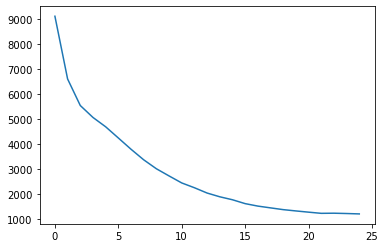

In [6]:
split_data =split_rnn(df,3)

x1_train,x2_train,y_train = split_data['train'] 

print('x1',x1_train.shape)
print('x2',x2_train.shape)
print('y',y_train.shape)
 
input1 = Input(shape=x1_train.shape[1])
input2 = Input(shape=x2_train.shape[1:])

layer1_rnn = LSTM(50,return_sequences=True,activation = 'relu')(input2)
layer2_rnn = LSTM(25,return_sequences=True,activation = 'relu')(layer1_rnn)
layer2_rnn = LSTM(10)(layer2_rnn)
layer1_dense = Dense(10)(input1) 
layer3 = Concatenate()([layer2_rnn,layer1_dense])
layer3 = Dense(10)(layer3)
output = Dense(1)(layer3)
model = Model(inputs=[input1,input2],outputs=[output])

print(model.summary())  

model.compile(optimizer='adam',
            loss='MeanSquaredError',
            metrics=['MeanSquaredError'])

history = model.fit([x1_train,x2_train],y_train,epochs=25)

plt.plot(history.history['loss'])
plt.show()

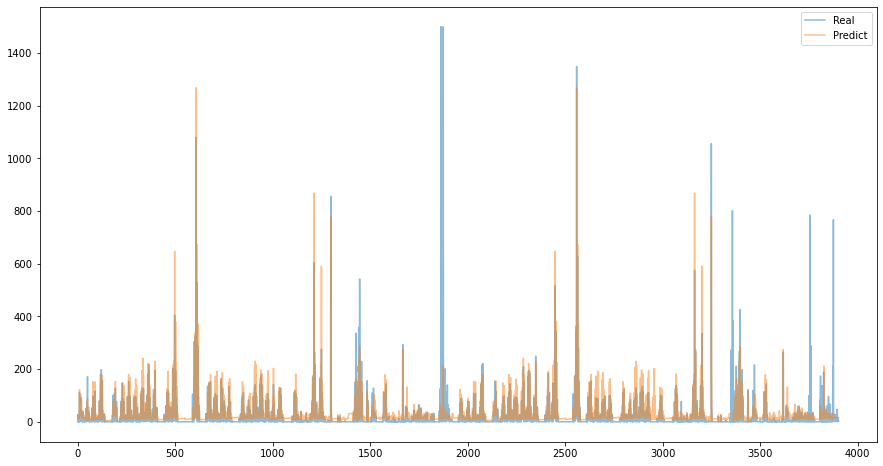

In [9]:
x1_test,x2_test,y_test = split_data['test']
y_pred = model.predict([x1_test,x2_test])
error = eval(y_test,y_pred)

plt.figure(figsize=(15,8))
plt.plot(y_test,alpha=0.5,label = 'Real')
plt.plot(y_pred,alpha=0.5,label = 'Predict')
plt.legend()
plt.show()

In [4]:
def calculate_cost_of_sales(cost,expense,quantity,initial_inventory=0):
    return (cost+expense)*(quantity+initial_inventory)

def 



def eval(y_true,y_pred):
    diff = abs(y_true-y_pred)
    return diff